In [32]:
import pandas as pd
import numpy as np
import matplotlib
import seaborn as sns
import gensim
import psycopg2
from gensim.models.ldamodel import LdaModel
from gensim import corpora

%matplotlib inline

In [5]:
conn=psycopg2.connect("dbname='scrapegame' user='rickwolf' password='mypass'")
conn.autocommit = True
cur = conn.cursor()

In [95]:
cur.execute("""
SELECT * FROM reviews
WHERE game_id = (SELECT gameid FROM games WHERE gametitle LIKE '%Binding of Isaac: Afterbirth')
""")

In [96]:
df = pd.DataFrame(cur.fetchall(), columns=['review_id', 'game_id', 'username', 'rev_text', 'date', 'score'])

In [97]:
df

,review_id,game_id,username,rev_text,date,score
0,7523,6320,Satisfaction,"Great DLC (despite the launch glitch, but I do...",2015-11-10,9
1,7524,6320,GYM11000,This is the best DLC that has ever existed. It...,2015-11-07,10
2,7525,6320,fergbot,A great expansion to Rebirth with plenty of in...,2015-11-07,9
3,7526,6320,tramper_94,The binding of isaac :afterbirth is the best r...,2015-11-04,10
4,7527,6320,DiesIre,Именно так и нужно делать DLC. За 150 рублей т...,2015-11-05,10
5,7528,6320,pikby,this is a perfect expansion to a perfect game ...,2015-12-01,9
6,7529,6320,Ladyvalhalla,"The waiting is over, the Binding of Isaac: aft...",2015-11-24,9
7,7530,6320,imnlol,DLC released with time gated content and major...,2015-11-07,7
8,7531,6320,buzz3791,Good for horror and sadists and that's about i...,2015-11-21,3
9,7532,6320,Tubey,I'm late to the party on Isaac - only played i...,2015-12-26,8


# Mess With Different Text Models

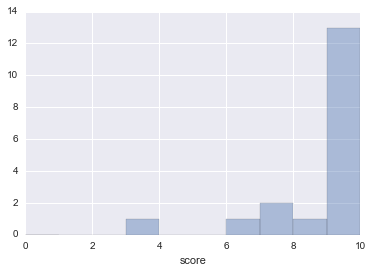

In [98]:
sns.distplot(df.score, bins=range(11), kde=False)

In [99]:
df.score.quantile()

9.0

Half of the scores are below 7, so start with that as the split for negative or positive

In [100]:
from nltk.corpus import stopwords 
from nltk.stem.wordnet import WordNetLemmatizer
import string
stop = set(stopwords.words('english'))
exclude = set(string.punctuation) 
lemma = WordNetLemmatizer()
def clean(doc):
    stop_free = " ".join([i for i in doc.lower().split() if i not in stop])
    punc_free = ''.join(ch for ch in stop_free if ch not in exclude)
    normalized = " ".join(lemma.lemmatize(word) for word in punc_free.split())
    return normalized

In [101]:
rev_clean = [clean(rev).split() for rev in df['rev_text']]

In [102]:
from collections import defaultdict
frequency = defaultdict(int)
for rev in rev_clean:
    for token in rev:
        frequency[token] += 1

In [103]:
rev_trimmed = [[token for token in text if frequency[token] > 1 and frequency[token] < 100] for text in rev_clean]

In [104]:
dictionary = corpora.Dictionary(rev_trimmed)
print(dictionary)

Dictionary(107 unique tokens: ['highly', 'im', 'whole', 'игры', 'bug']...)


In [105]:
doc_term_matrix = [dictionary.doc2bow(doc) for doc in rev_trimmed]

In [106]:
ldamod = LdaModel(doc_term_matrix, num_topics=3, id2word = dictionary, passes=100)
for topic in ldamod.print_topics(num_topics=10, num_words=15):
    print(topic)

(0, '0.029*"content" + 0.029*"amount" + 0.029*"great" + 0.029*"bug" + 0.029*"rebirth" + 0.029*"hopefully" + 0.029*"fixed" + 0.029*"expansion" + 0.029*"interesting" + 0.029*"back" + 0.028*"come" + 0.007*"yet" + 0.007*"fan" + 0.007*"like" + 0.007*"greed"')
(1, '0.046*"и" + 0.037*"it" + 0.037*"afterbirth" + 0.029*"personally" + 0.029*"thought" + 0.029*"expensive" + 0.029*"nuevos" + 0.029*"un" + 0.029*"en" + 0.029*"в" + 0.024*"price" + 0.021*"rebirth" + 0.021*"dlc" + 0.020*"well" + 0.020*"fun"')
(2, '0.079*"game" + 0.070*"new" + 0.041*"dlc" + 0.026*"item" + 0.023*"it" + 0.022*"rebirth" + 0.020*"mode" + 0.017*"much" + 0.017*"really" + 0.017*"one" + 0.017*"add" + 0.017*"time" + 0.017*"isaac" + 0.017*"great" + 0.014*"get"')


In [112]:
ldamod.show_topic(0)

[('content', 0.029287889511613117),
 ('amount', 0.029058563523957023),
 ('great', 0.029022104517062473),
 ('bug', 0.028772550704869986),
 ('rebirth', 0.028742719470609912),
 ('hopefully', 0.028595623294981783),
 ('fixed', 0.028595623288778956),
 ('expansion', 0.028593438837504061),
 ('interesting', 0.028583615117270644),
 ('back', 0.028583615112125569)]

In [114]:
from gensim import similarities

In [115]:
from sklearn.metrics.pairwise import cosine_similarity
dist = 1 - cosine_similarity(doc_term_matrix)
print
print

ValueError: setting an array element with a sequence.